## Parallelize search over several parameters

In [27]:
import itertools
from typing import Iterator, List, Tuple
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from spear.assets import Asset, PretaxAsset, TaxableAsset, PretaxPortfolio, TaxablePortfolio
from spear.events import Action, Event
from spear.flows import Expense, TaxableIncome
from spear.model import FinancialModel

# Set basic inputs
# Housing inputs
HOUSE_PRICE = 0
MORTGAGE_DURATION = 30
MORTGAGE_INTEREST_RATE = 0.06

# Kobold IPO inputs
KOBOLD_STOCK_EARNINGS = 900_000

# Cost of living inputs
COST_OF_LIVING_EXPENSE = 50_000

# Kid inputs
ANNUAL_COST_PER_KID = 25_000

house_prices = Asset(name="House prices", initial_value=HOUSE_PRICE, growth_rate=0.04)
for y in range(2024, 2100):
    house_prices.grow(y)

down_payments = Asset(name="Down payments", initial_value=200_000, growth_rate=0.03)
for y in range(2024, 2100):
    down_payments.grow(y)

In [28]:
buy_house_years = (2080, 2081) # 2025, 2032
have_kids_years = (2080, 2081) # 2027, 2034
kobold_ipos_years = (2080, 2081) # 2027, 2035
stop_investing_in_401k_years = (2050, 2051) # 2050, 2051

quit_job_years = (2025, 2045)

In [29]:
def instantiate_revenues() -> List[TaxableIncome]:
    salary = TaxableIncome(name="Salary", initial_value=310_000, state="MA")
    return salary

def instantiate_expenses() -> List[Expense]:
    housing = Expense(name="Housing", initial_value=40_000, inflation_rate=0.02)
    cost_of_living = Expense(name="Cost of Living", initial_value=COST_OF_LIVING_EXPENSE, inflation_rate=0.03)
    health_insurance = Expense(name="Health Insurance", initial_value=0, inflation_rate=0.03)
    mortgage = Expense(name="Mortgage", initial_value=0, inflation_rate=0.0)
    return housing, cost_of_living, health_insurance, mortgage

def instantiate_assets() -> List[Asset]:
    cash = Asset(name="Cash", initial_value=50_000, growth_rate=0.01, cap_value=50_000)
    bonds = TaxableAsset(name="Bonds", initial_value=200_000, growth_rate=0.03, allocation=0)
    stocks = TaxablePortfolio(
        name="Stocks",
        initial_value=180_000,
        age=30,
        seed=42,
        sample_growth_rates=True,
        allocation=1
    )

    _401k = PretaxPortfolio(
        name="401k",
        initial_value=280_000, # Includes 120k in 401k and 20k in Roth IRA per person
        cap_deposit=46_000,
        pretax=True,
        sample_growth_rates=True,
        seed=42,
        age=30,
        state="MA",
    )

    return cash, bonds, stocks, _401k

def instantiate_events(
        buy_house_year: int,
        quit_job_year: int,
        have_kid_year: int,
        stop_investing_in_401k_year: int,
        kobold_ipos_year: int,
        mortgage_duration: int,
        salary: TaxableIncome,
        health_insurance: Expense,
        mortgage: Expense,
        cash: Asset,
        bonds: TaxableAsset,
        stocks: TaxableAsset,
        _401k: PretaxAsset,
        housing: Expense,
        cost_of_living: Expense
) -> List[Event]:
    quit_job = Event(
        name="Quit Job",
        year=quit_job_year,
        actions=[
            Action(
                target=salary,
                action="update_base_values",
                params={"new_base_values": 0, "duration": 100},
            ),
            Action(
                target=health_insurance,
                action="update_base_values",
                params={"new_base_values": 6_000, "duration": 100},
            ),
        ],
    )
    house_price = house_prices[buy_house_year]
    down_payment = min(max(0.2 * house_price, down_payments[buy_house_year]), house_price)
    loaned_amount = house_price - down_payment

    def get_monthly_mortgage(loaned_amount: float, interest_rate: float, years: int) -> float:
        n = years * 12
        r = interest_rate / 12
        return loaned_amount * (r * (1 + r) ** n) / ((1 + r) ** n - 1)

    yearly_mortgage = 12 * get_monthly_mortgage(loaned_amount, MORTGAGE_INTEREST_RATE, mortgage_duration)

    buy_house = Event(
        name="Buy House",
        year=buy_house_year,
        actions=[
            Action(target=bonds, action="withdraw", params={"amount": down_payment}),
            Action(target=housing, action="update_base_values", params={"new_base_values": 10_000, "duration": 100}),
            Action(target=mortgage, action="update_base_values", params={"new_base_values": yearly_mortgage}),
        ],
    )

    end_mortgage = Event(
        name="End Mortgage",
        year=buy_house_year + mortgage_duration,
        actions=[
            Action(target=mortgage, action="update_base_values", params={"new_base_values": 0, "duration": 100}),
        ],
    )

    have_kid = Event(
        name="Have Kid",
        year=have_kid_year,
        actions=[
            Action(target=cost_of_living, action="add_to_base_values", params={"to_add": ANNUAL_COST_PER_KID, "duration": 20}),
        ],
        # Source: https://bostonuncovered.com/childcare-cost-boston/
    )

    kid_leaves = Event(
        name="Kid Leaves",
        year=have_kid_year + 18,
        actions=[
            Action(target=cost_of_living, action="add_to_base_values", params={"to_add": -ANNUAL_COST_PER_KID, "duration": 1}),
        ],
    )

    stop_investing_in_401k = Event(
        name="Stop Investing in 401k",
        year=stop_investing_in_401k_year,
        actions=[Action(target=_401k, action="update_cap_deposit", params={"cap_deposit": 0})],
    )

    kobold_ipos = Event(
        name="Kobold Ipos",
        year=kobold_ipos_year,
        actions=[Action(target=salary, action="add_to_base_values", params={"to_add": KOBOLD_STOCK_EARNINGS})],
    )

    return quit_job, buy_house, end_mortgage, have_kid, kid_leaves, stop_investing_in_401k, kobold_ipos


In [30]:
def generate_parameter_combinations(parameters: List[Tuple[int, int]]) -> Iterator[Tuple]:
    """
    Generate all combinations of parameters for ranges generated by start and end.

    Parameters
    ----------
    parameters: List[Tuple[int, int]]
        List of tuples, where each tuple contains the start and end of a range.

    Returns
    -------
    Iterator[Tuple]
        An iterator with all combinations of parameters.
    """
    # Expand each tuple into a range
    expanded_parameters = [range(start, end) for start, end in parameters]
    return itertools.product(*expanded_parameters)

def run_simulation(params: Tuple[int, int, int]) -> Tuple[int, int, int, FinancialModel]:

    buy_house_year, quit_job_year, have_kid_year, stop_investing_in_401k_year, kobold_ipos_year = params

    salary = instantiate_revenues()
    housing, cost_of_living, health_insurance, mortgage = instantiate_expenses()
    cash, bonds, stocks, _401k = instantiate_assets()
    quit_job, buy_house, end_mortgage, have_kid, kid_leaves, stop_investing_in_401k, kobold_ipos = instantiate_events(
        buy_house_year=buy_house_year, 
        quit_job_year=quit_job_year, 
        have_kid_year=have_kid_year,
        stop_investing_in_401k_year=stop_investing_in_401k_year,
        kobold_ipos_year=kobold_ipos_year,
        mortgage_duration=MORTGAGE_DURATION,
        salary=salary, 
        health_insurance=health_insurance, 
        mortgage=mortgage,
        cash=cash,
        bonds=bonds,
        stocks=stocks, 
        _401k=_401k,
        housing=housing,
        cost_of_living=cost_of_living
    )

    model = FinancialModel(
        revenues=[salary],
        expenses=[housing, cost_of_living, health_insurance, mortgage],
        assets=[cash, bonds, stocks, _401k],
        events=[quit_job, buy_house, end_mortgage, have_kid, kid_leaves, stop_investing_in_401k, kobold_ipos],
        duration=50,
        number_of_simulations=1_000,
    )
    model.run()

    # Count the number of simulations where debt is never positive (i.e. successful early retirement)
    count = np.sum(np.all(model.debt.base_values <= 0, axis=1))
    count -= 1 # Remove the first row that always returns 0 debt
    fraction_of_debt_free_cases = (count / model.number_of_simulations)
    metric = fraction_of_debt_free_cases
    return buy_house_year, quit_job_year, have_kid_year, stop_investing_in_401k_year, kobold_ipos_year, metric, model


In [31]:
# Test run_simulation works
run_simulation((2025, 2029, 2028, 2029, 2030))

(2025,
 2029,
 2028,
 2029,
 2030,
 np.float64(0.396),
 FinancialModel(revenues=[TaxableIncome(name='Salary', initial_value=310000, start_year=2024, duration=100, multiplier=1, number_of_simulations=1000)], expenses=[Expense(name='Housing', initial_value=40000, start_year=2024, duration=100, multiplier=1.02, number_of_simulations=1000), Expense(name='Cost of Living', initial_value=50000, start_year=2024, duration=100, multiplier=1.03, number_of_simulations=1000), Expense(name='Health Insurance', initial_value=0, start_year=2024, duration=100, multiplier=1.03, number_of_simulations=1000), Expense(name='Mortgage', initial_value=0, start_year=2024, duration=100, multiplier=1.0, number_of_simulations=1000)], assets=[Asset(name='Cash', initial_value=50000, start_year=2024, duration=100, multiplier=1.01, number_of_simulations=1000), TaxableAsset(name='Bonds', initial_value=200000, start_year=2024, duration=100, multiplier=1.03, number_of_simulations=1000), TaxablePortfolio(name='Taxable Port

In [32]:
parameter_combinations = generate_parameter_combinations([buy_house_years, quit_job_years, have_kids_years, stop_investing_in_401k_years, kobold_ipos_years])
results = Parallel(n_jobs=-1)(delayed(run_simulation)(params) for params in parameter_combinations)

In [33]:
columns = ["buy_house_year", "quit_job_year", "have_kid_year", "stop_investing_in_401k_year", "kobold_ipos_year", "metric", "model"]
results_df = pd.DataFrame(results, columns=columns)
results_df.head()

,buy_house_year,quit_job_year,have_kid_year,stop_investing_in_401k_year,kobold_ipos_year,metric,model
0,2080,2025,2080,2050,2080,-0.001,FinancialModel(revenues=[TaxableIncome(name='S...
1,2080,2026,2080,2050,2080,-0.001,FinancialModel(revenues=[TaxableIncome(name='S...
2,2080,2027,2080,2050,2080,-0.001,FinancialModel(revenues=[TaxableIncome(name='S...
3,2080,2028,2080,2050,2080,0.002,FinancialModel(revenues=[TaxableIncome(name='S...
4,2080,2029,2080,2050,2080,0.019,FinancialModel(revenues=[TaxableIncome(name='S...


Cost of living expense:  50000

Buy house years:  (2080, 2081)
House price:  0
Mortgage interest rate:  0.06
Mortgage duration:  30

Have kids years:  (2080, 2081)
Annual cost per kid:  25000

Kobold ipos years:  (2080, 2081)
Kobold stock earnings:  900000

Stop investing in 401k years:  (2050, 2051)

Quit job years:  (2025, 2045)


<Axes: xlabel='quit_job_year', ylabel='buy_house_year'>

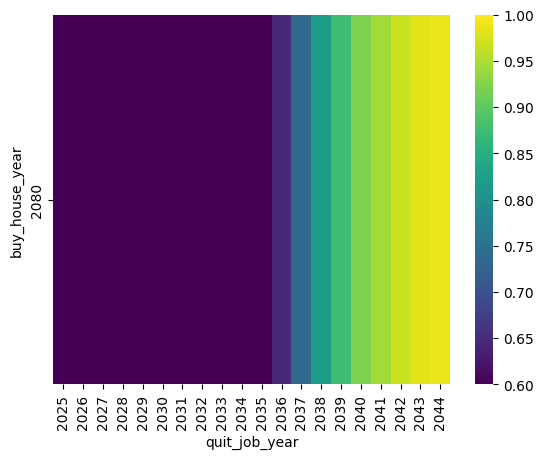

In [34]:
import seaborn as sns

print("Cost of living expense: ", COST_OF_LIVING_EXPENSE)

print("\nBuy house years: ", buy_house_years)
print("House price: ", HOUSE_PRICE)
print("Mortgage interest rate: ", MORTGAGE_INTEREST_RATE)
print("Mortgage duration: ", MORTGAGE_DURATION)

print("\nHave kids years: ", have_kids_years)
print("Annual cost per kid: ", ANNUAL_COST_PER_KID)

print("\nKobold ipos years: ", kobold_ipos_years)
print("Kobold stock earnings: ", KOBOLD_STOCK_EARNINGS)

print("\nStop investing in 401k years: ", stop_investing_in_401k_years)

print("\nQuit job years: ", quit_job_years)

sns.heatmap(results_df.pivot(index="buy_house_year", columns="quit_job_year", values="metric"), cmap="viridis", vmin=0.6, vmax=1)

Cost of living expense:  38000

Buy house years:  (2025, 2026)
House price:  200000
Mortgage interest rate:  0.04
Mortgage duration:  30

Have kids years:  (2080, 2081)
Annual cost per kid:  25000

Kobold ipos years:  (2027, 2035)
Kobold stock earnings:  900000

Stop investing in 401k years:  (2050, 2051)

Quit job years:  (2025, 2035)


<Axes: xlabel='quit_job_year', ylabel='kobold_ipos_year'>

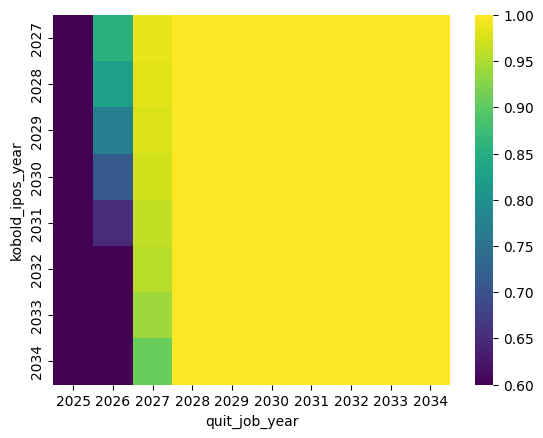

In [22]:
import seaborn as sns

print("Cost of living expense: ", COST_OF_LIVING_EXPENSE)

print("\nBuy house years: ", buy_house_years)
print("House price: ", HOUSE_PRICE)
print("Mortgage interest rate: ", MORTGAGE_INTEREST_RATE)
print("Mortgage duration: ", MORTGAGE_DURATION)

print("\nHave kids years: ", have_kids_years)
print("Annual cost per kid: ", ANNUAL_COST_PER_KID)

print("\nKobold ipos years: ", kobold_ipos_years)
print("Kobold stock earnings: ", KOBOLD_STOCK_EARNINGS)

print("\nStop investing in 401k years: ", stop_investing_in_401k_years)

print("\nQuit job years: ", quit_job_years)

sns.heatmap(results_df.pivot(index="buy_house_year", columns="quit_job_year", values="metric"), cmap="viridis", vmin=0.6, vmax=1)


<Axes: xlabel='quit_job_year', ylabel='have_kid_year'>

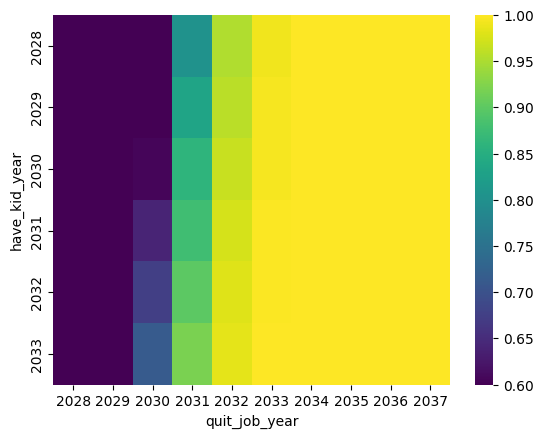

In [405]:
import seaborn as sns

print("Cost of living expense: ", COST_OF_LIVING_EXPENSE)

print("\nBuy house years: ", buy_house_years)
print("House price: ", HOUSE_PRICE)
print("Mortgage interest rate: ", MORTGAGE_INTEREST_RATE)
print("Mortgage duration: ", MORTGAGE_DURATION)

print("\nHave kids years: ", have_kids_years)
print("Annual cost per kid: ", ANNUAL_COST_PER_KID)

print("\nKobold ipos years: ", kobold_ipos_years)
print("Kobold stock earnings: ", KOBOLD_STOCK_EARNINGS)

print("\nStop investing in 401k years: ", stop_investing_in_401k_years)

print("\nQuit job years: ", quit_job_years)

sns.heatmap(results_df.pivot(index="have_kid_year", columns="quit_job_year", values="metric"), cmap="viridis", vmin=0.6, vmax=1)


<Axes: xlabel='quit_job_year', ylabel='buy_house_year'>

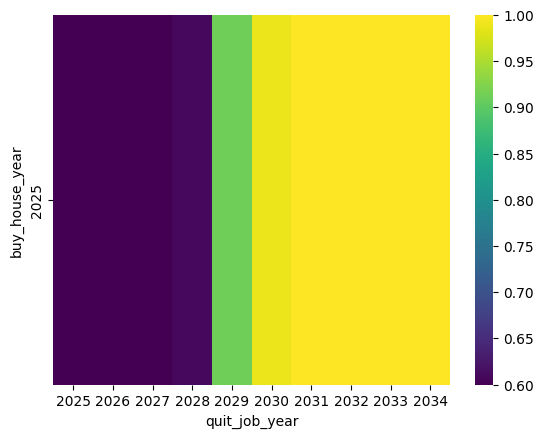

: 

In [422]:
import seaborn as sns

print("Cost of living expense: ", COST_OF_LIVING_EXPENSE)

print("\nBuy house years: ", buy_house_years)
print("House price: ", HOUSE_PRICE)
print("Mortgage interest rate: ", MORTGAGE_INTEREST_RATE)
print("Mortgage duration: ", MORTGAGE_DURATION)

print("\nHave kids years: ", have_kids_years)
print("Annual cost per kid: ", ANNUAL_COST_PER_KID)

print("\nKobold ipos years: ", kobold_ipos_years)
print("Kobold stock earnings: ", KOBOLD_STOCK_EARNINGS)

print("\nStop investing in 401k years: ", stop_investing_in_401k_years)

print("\nQuit job years: ", quit_job_years)

sns.heatmap(results_df.pivot(index="buy_house_year", columns="quit_job_year", values="metric"), cmap="viridis", vmin=0.6, vmax=1)


In [36]:
# buy house year from 2031-2032 and quit job year from 2031-2032
planners_to_view = results_df.query("buy_house_year >= 2025 and buy_house_year <= 2090 and \
                                    quit_job_year >= 2035 and quit_job_year <= 2040")
planners_to_view

,buy_house_year,quit_job_year,have_kid_year,stop_investing_in_401k_year,kobold_ipos_year,metric,model
10,2080,2035,2080,2050,2080,0.544,FinancialModel(revenues=[TaxableIncome(name='S...
11,2080,2036,2080,2050,2080,0.646,FinancialModel(revenues=[TaxableIncome(name='S...
12,2080,2037,2080,2050,2080,0.735,FinancialModel(revenues=[TaxableIncome(name='S...
13,2080,2038,2080,2050,2080,0.821,FinancialModel(revenues=[TaxableIncome(name='S...
14,2080,2039,2080,2050,2080,0.876,FinancialModel(revenues=[TaxableIncome(name='S...
15,2080,2040,2080,2050,2080,0.921,FinancialModel(revenues=[TaxableIncome(name='S...


In [37]:
#planners_to_view.iloc[0].model.get_expense("Cost of Living").plot(duration=80)
#planners_to_view.iloc[0].model.get_expense("Mortgage").plot(duration=80)

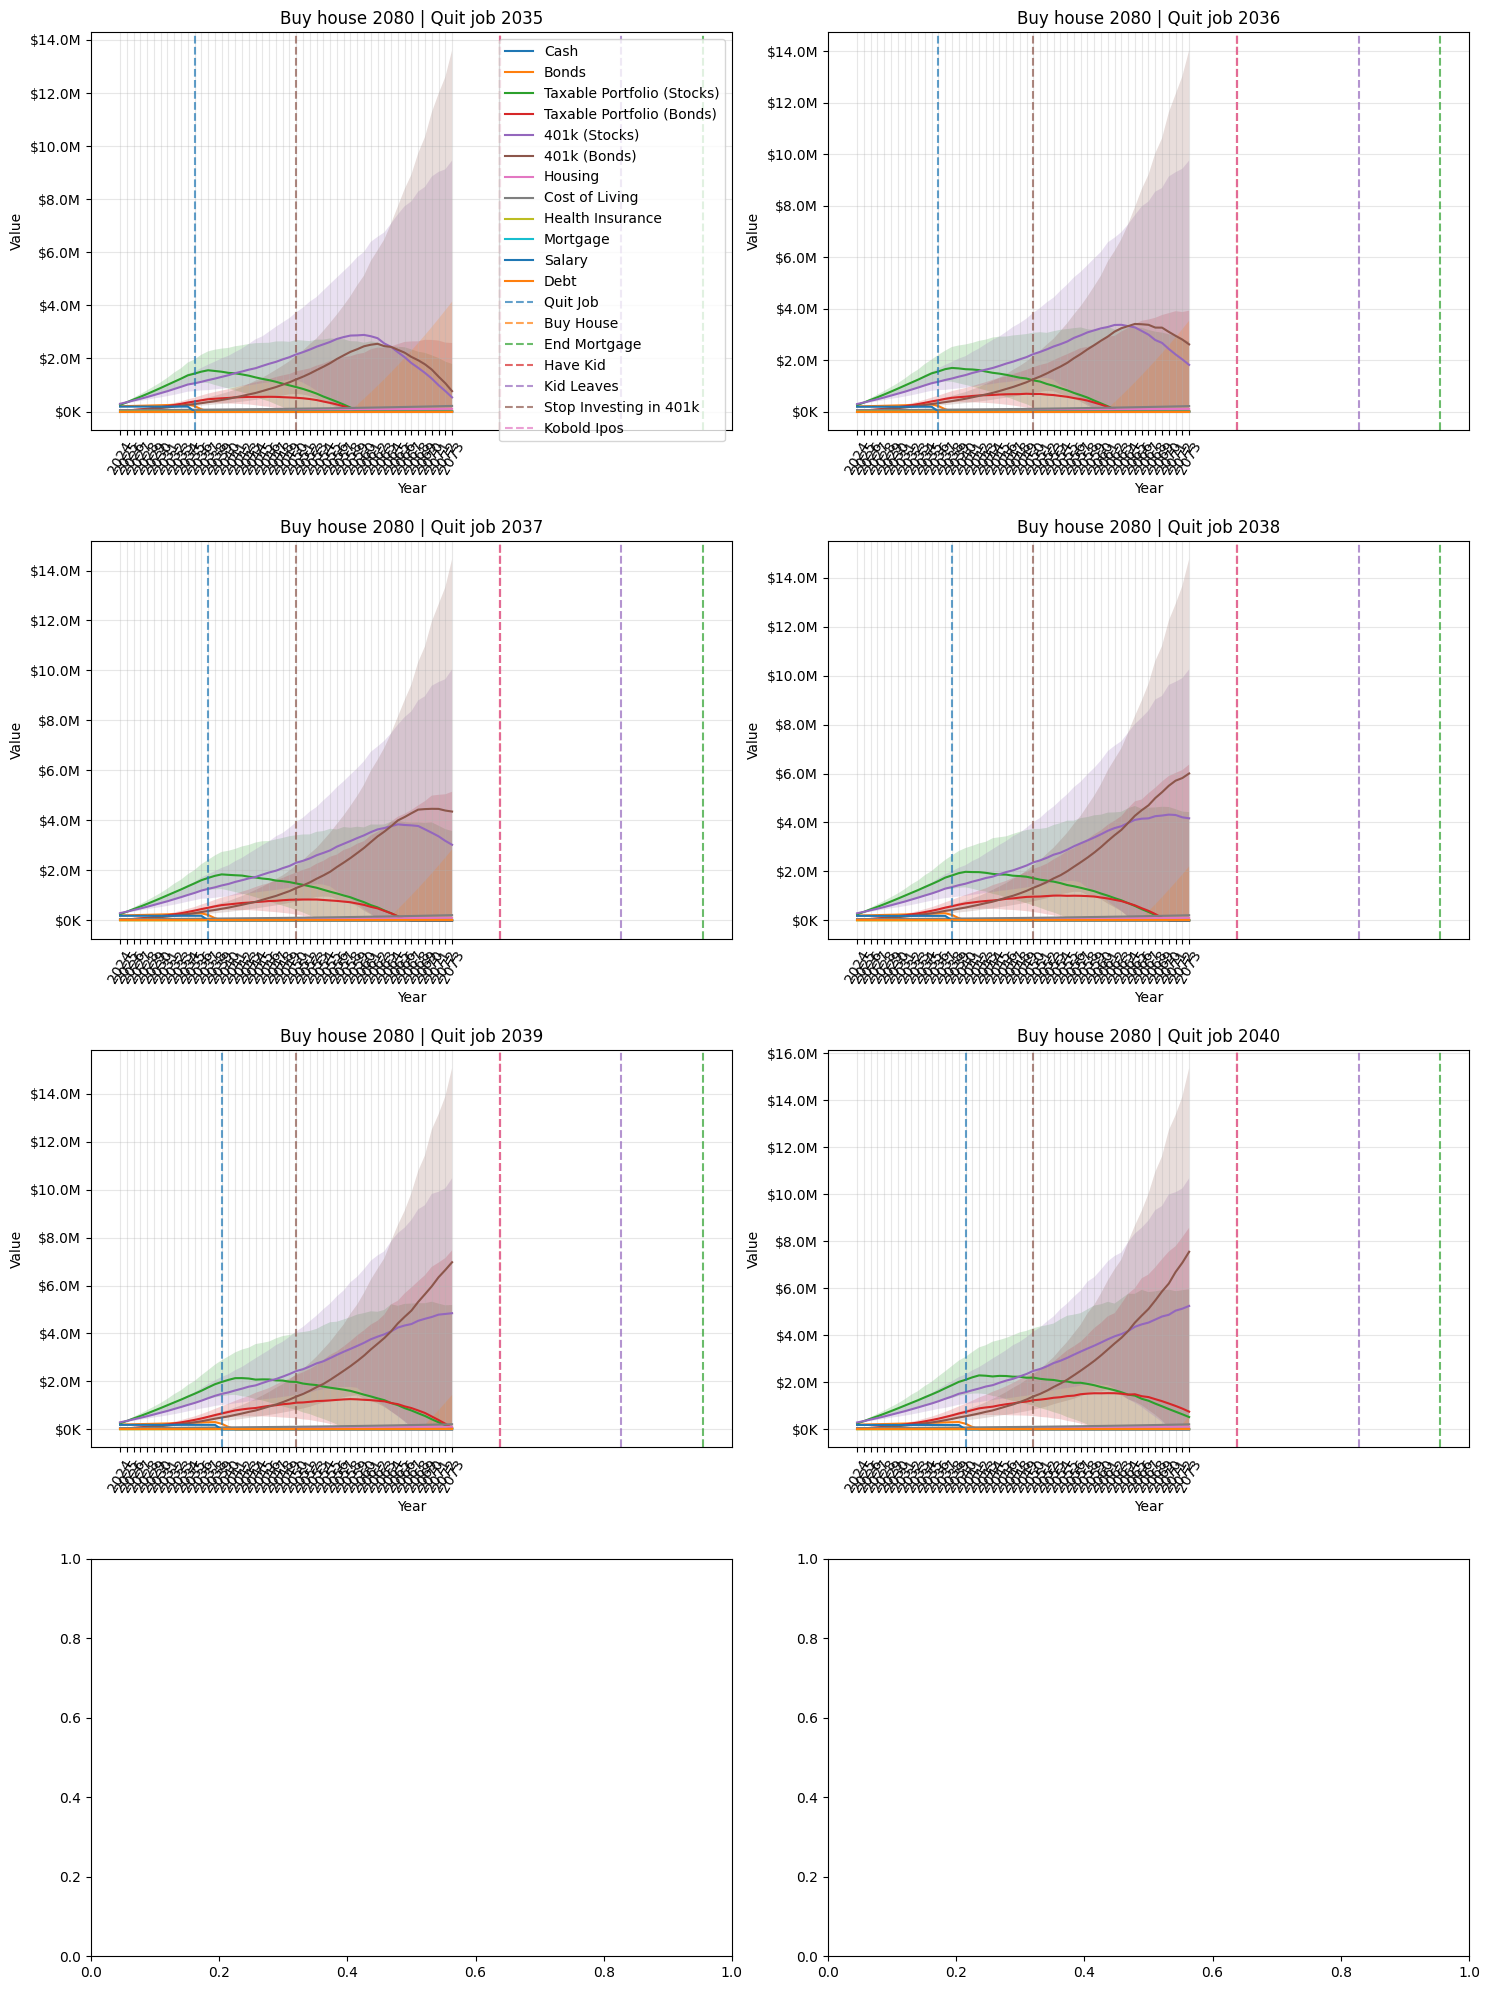

In [38]:
from matplotlib import pyplot as plt

# Order of years in dictionary key: house purchase, retirement, 401k stop
fig, axes = plt.subplots(len(planners_to_view)//2 + 1, 2, figsize=(15,20))
for ax, (_, p) in zip(axes.ravel(), planners_to_view.iterrows()):
    ax = p.model.plot_all(ax);
    ax.set_title(f"Buy house {p['buy_house_year']} | Quit job {p['quit_job_year']}")

# Show legend only for the first graph
for i, ax in enumerate(axes.ravel()):
    if i == 0:
        ax.legend()
    else:
        try:
            ax.get_legend().remove()
        except:
            pass

plt.tight_layout()

In [ ]:
p.model.get_asset("Stocks").plot(duration=80)

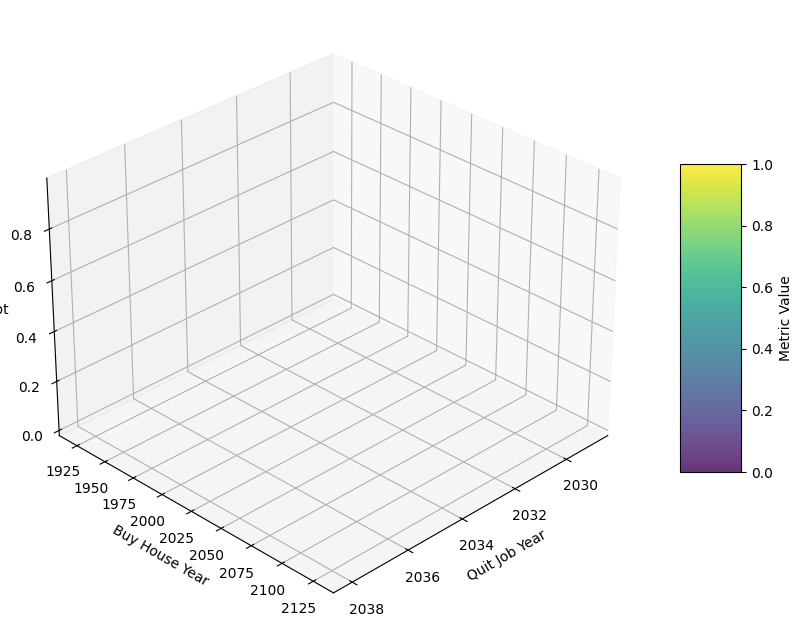

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# Create a pivot table
pivot_df = results_df.pivot_table(values='metric', 
                                  index='buy_house_year', 
                                  columns='quit_job_year', 
                                  )

# Create a meshgrid for the x and y axes
X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, pivot_df.values, cmap='viridis', 
                       rstride=1, cstride=1, antialiased=False, alpha=0.8)

# Set labels and title
ax.set_xlabel('Quit Job Year')
ax.set_ylabel('Buy House Year')
ax.set_zlabel('Debt')

# Add a color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Metric Value')

# Improve the angle for better visibility
ax.view_init(elev=30, azim=45)

In [162]:
# Get the row with index 323
row_323 = results_df.iloc[323]

# Display the row
print(row_323)


IndexError: single positional indexer is out-of-bounds

<Axes: xlabel='Year', ylabel='Value'>

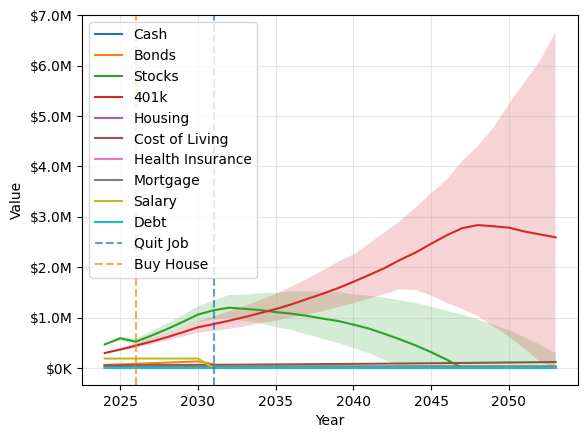

In [ ]:
model = results_df.query("quit_job_year == 2031").iloc[0].model
model.plot_all()


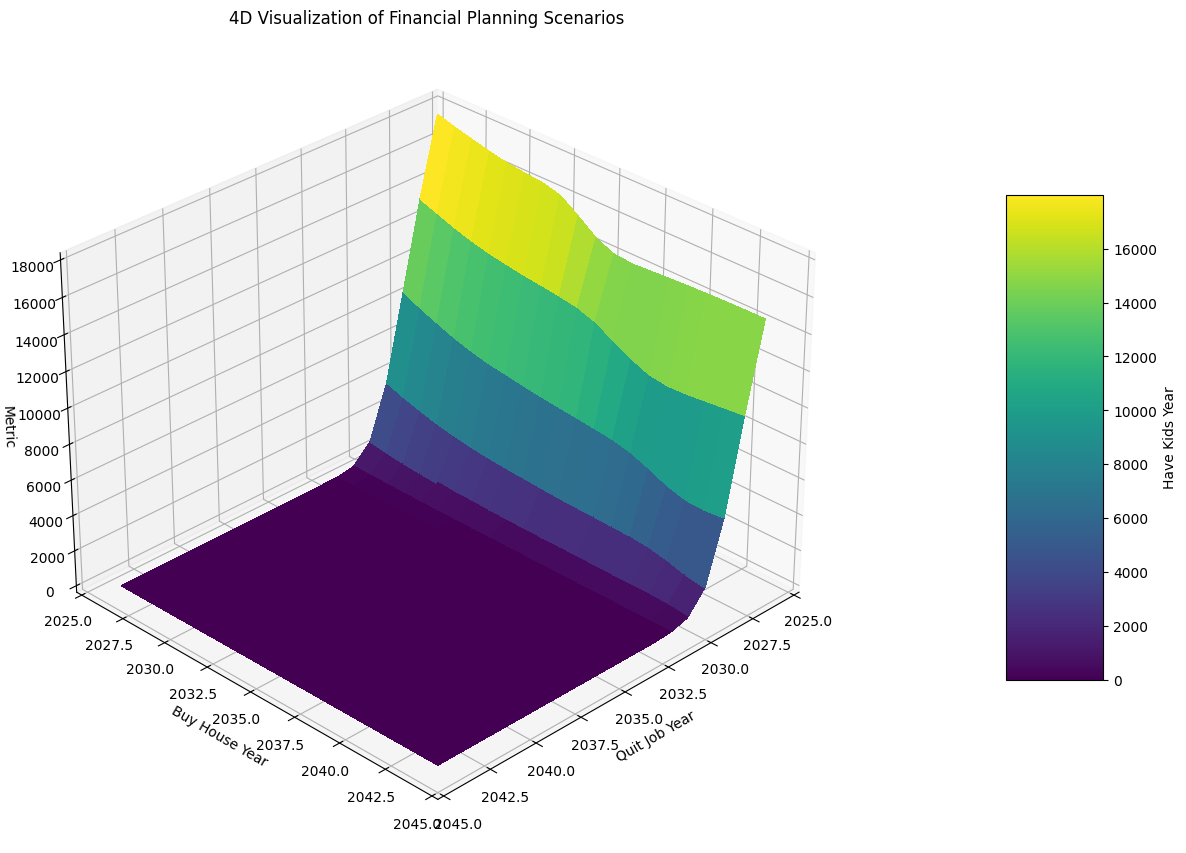

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create pivot tables for metric and have_kids_year
metric_pivot = results_df.pivot(index='buy_house_year', columns='quit_job_year', values='metric')
kids_pivot = results_df.pivot(index='buy_house_year', columns='quit_job_year', values='metric')

# Create a meshgrid for the x and y axes
X, Y = np.meshgrid(metric_pivot.columns, metric_pivot.index)

# Create the 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, metric_pivot.values, 
                       facecolors=plt.cm.viridis(kids_pivot.values/kids_pivot.values.max()),
                       rstride=1, cstride=1, antialiased=False, shade=False)

# Set labels and title
ax.set_xlabel('Quit Job Year')
ax.set_ylabel('Buy House Year')
ax.set_zlabel('Metric')
ax.set_title('4D Visualization of Financial Planning Scenarios')

kids_sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=kids_pivot.values.min(), vmax=kids_pivot.values.max()))
kids_sm.set_array([])
cbar_kids = fig.colorbar(kids_sm, ax=ax, shrink=0.5, aspect=5, pad=0.15, label='Have Kids Year')

# Improve the angle for better visibility
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()
